In [1]:
import json
import yaml
from pathlib import Path

import torch
from torchmetrics.wrappers import BootStrapper

import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba

from tqdm import tqdm

from scaling.models.module import LitModel
from scaling.datasets.physionet import PhysionetDM
from scaling.augmentations import ECGAugmentation
from scaling.metrics import scalar_metrics, PhysionetMetric
from scaling.datasets.physionet import CLASSES, SINUS_RYTHM, WEIGHTS
from scaling.models.model_factory import MODELS

In [2]:
def count_params(model):
    return sum([x.numel() for x in model.parameters() if x.requires_grad])

In [3]:
_ = MODELS.pop("scalable_resnet") # Slightly different functionality. Has to be removed

model_sizes = {k: count_params(v()) for k, v in MODELS.items()}

# Loading training summarys

In [4]:
def load_summary(summary: Path) -> dict:
    with summary.open(mode="r") as file:
        return json.load(file)

def load_config(path: Path) -> dict:
    with path.open(mode="r") as file:
        return yaml.safe_load(file)

def get_model_name_from_config(path: Path) -> str:
    config = load_config(path)
    return config["model_name"]["value"]

In [7]:
summarys = []
for run in Path("../wandb").iterdir():
    if not run.name.startswith("run"):
        continue

    config_file = run / "files" / "config.yaml"
    summary_file = run / "files" / "wandb-summary.json"
    
    if not config_file.is_file() or not summary_file.is_file():
        continue
    
    config = load_config(config_file)
    summary = load_summary(summary_file) 
    
    wandb_stats = summary.pop("_wandb")
    for k, v in wandb_stats.items():
        summary[k] = v

    summary["model_name"] = config["model_name"]["value"]
    summary["loss_fn"] = config["loss_fn"]["value"]
    summary["fold"] = config["fold"]["value"]

    summary["wandb_id"] = run.name.split("-")[-1]

    summarys.append(summary)
df = pd.DataFrame(summarys)
df["model_size"] = df.model_name.map(lambda x: model_sizes[x])

# Loading saved models

In [8]:
top_model = {
    "AUPRC": 0.548,
    "AUROC": 0.949,
    "Accuracy": 0.418,
    "F-Measure": 0.521,
    "Challenge Score": 0.696
}

In [9]:
class CheckpointLoader:
    def __init__(self, ckpt_path, df):
        self.ckpt_path = Path(ckpt_path)
        self.df = df

    def load(self, **filter_args):
        _id = self.checkpoint_id(**filter_args)
        ckpt = next((self.ckpt_path / _id).rglob("*.ckpt"))
        return LitModel.load_from_checkpoint(ckpt)
    
    def checkpoint_id(self, **filter_args):
        _df = self.df.copy()
        
        # Apply the filtering
        for key, value in filter_args.items():
            if key in _df.columns:
                _df = _df[_df[key] == value]
            else:
                raise KeyError(f"Column '{key}' does not exist in the dataframe.")

        if len(_df) > 1:
            print(f"WARN: Filter more!! I got {len(_df)} samples fitting the criteria {filter_args}.")
            _df = _df.iloc[[0]]

        if len(_df) == 0:
            raise ValueError("Model not Found!")
        sample = _df["wandb_id"].item()
        return sample

In [10]:
def evaluate_model(model, model_name="", quantile=0.5, num_bootstraps=10):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    model = model.eval().to(device)

    # Metrics
    metrics = scalar_metrics()
    physiomet = PhysionetMetric(WEIGHTS, CLASSES, SINUS_RYTHM)
    bootstrap = BootStrapper(physiomet, num_bootstraps=num_bootstraps, quantile=quantile)

    # Dataset
    valid_transform = ECGAugmentation()
    train_transform = ECGAugmentation()
    dm = PhysionetDM("/sc-scratch/sc-scratch-gbm-radiomics/ecg/physionet_challenge/training_pt/metadata_v5.csv", train_transform=train_transform, val_transform=valid_transform, fold=0)
    dm.setup()
    dataloader = dm.val_dataloader()
    dataloader.num_workers = 32
    dataloader.prefetch_factor = 2

    # Evaluate
    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(dataloader, total=len(dataloader), desc=model_name)):
            pred = model(x.to(device))
            pred, y = pred.cpu(), y.int().cpu()

            metrics(pred, y)
            bootstrap.update(pred, y)

    # Format output
    result = metrics.compute()
    for k, v in bootstrap.compute().items():
        result[f"PhysioAccuracy_{k}"] = v

    for k, v in result.items():
        result[k] = v.item()

    result["model_name"] = model_name
    
    return result

In [11]:
loader = CheckpointLoader("../PhysioNetScaling", df)

In [12]:
# # Generate results
# results = []
# for model_name in list(df.loc[(df.loss_fn == "ASL") & (df.fold == 0), "model_name"]):
#     if model_name in done:
#         continue
#     model = loader.load(model_name=model_name, loss_fn="ASL")

#     result = evaluate_model(model, model_name)
#     results.append(result)

# results = pd.DataFrame(results)
# results.to_csv("evaluation.csv")

# Load results
results = pd.read_csv("evaluation.csv", index_col=0)

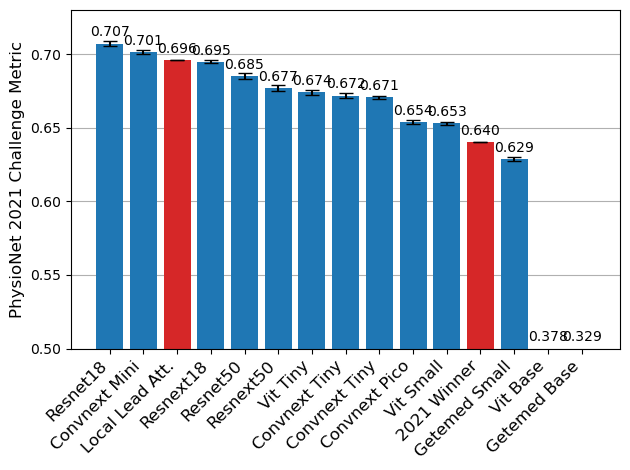

In [13]:
# Add new data point
new_model = pd.DataFrame({
    "model_name": ["Local Lead Att.", "2021 Winner"],
    "PhysioAccuracy_mean": [0.696, 0.640],
    "PhysioAccuracy_std": [0.0, 0.0]
})
_results = pd.concat([results, new_model], ignore_index=True)

# Sort by PhysioAccuracy_mean
_results = _results.sort_values(by="PhysioAccuracy_mean", ascending=False).reset_index(drop=True)

# Data for the bar plot
x = np.arange(len(_results))  # Positions for the bars
y = _results["PhysioAccuracy_mean"]  # Mean values
yerr = _results["PhysioAccuracy_std"]  # Error bars

bar_colors = ['tab:blue'] * 13
for make_red in np.unique(np.where(_results.isna())[0]):
    bar_colors[make_red] = "tab:red"

# Create the bar plot
fig, ax = plt.subplots()
bars = ax.bar(x, y, yerr=yerr, capsize=5, zorder=2, color=bar_colors)

# Add labels to each bar
for bar in bars:
    height = bar.get_height()
    y = max([height, 0.5])
    ax.annotate(f'{height:.3f}',  # Format the label
                xy=(bar.get_x() + bar.get_width() * 0.5, y),  # Position
                xytext=(0, 3),  # Offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(_results["model_name"].apply(lambda x: x.replace("_", " ").title()), fontsize=12, rotation=45, ha="right")

ax.set_ylim(0.5, 0.73)

ymax = _results["PhysioAccuracy_mean"].max() + _results["PhysioAccuracy_std"].max()
ax.grid(axis="y")
ax.set_xlabel("")
ax.set_ylabel("PhysioNet 2021 Challenge Metric", fontsize=12)

plt.tight_layout()
plt.savefig("./plots/baseline_performance.png", dpi=280)
plt.show()

In [14]:
# Preparation for bubble plots

results["model_size"] = results.model_name.apply(lambda x: model_sizes[x])

model_hue_order = [
    'resnet18',
    'resnet50',
    'resnext18',
    'resnext50',
    'convnext_pico',
    'convnext_mini',
    'convnext_tiny',
    'getemed_small',
    'vit_tiny',
    'vit_small',
]

# Define the group sizes
group_sizes = [2, 2, 3, 1, 2]

# Base colormap (e.g., tab20)
base_cmap = plt.get_cmap("tab10")

# Generate slightly different colors for each group
colors = []
color_idx = 0  # Track base color index

for group_size in group_sizes:
    base_color = np.array(to_rgba(base_cmap(color_idx)))  # Base color
    for i in range(group_size):
        # Adjust brightness slightly for pairs
        factor = 1 - 0.3 * (i % group_size)  # Slightly darker shades within the group
        adjusted_color = base_color * factor
        adjusted_color[3] = base_color[3]  # Preserve alpha
        colors.append(adjusted_color)
    color_idx += 1

# Create the custom colormap
custom_cmap = ListedColormap(colors)

sorted_data = results[~results.model_name.isin(["vit_base", "getemed_base"])].sort_values("model_name")
sorted_data = sorted_data.groupby("model_name", as_index=False).mean()

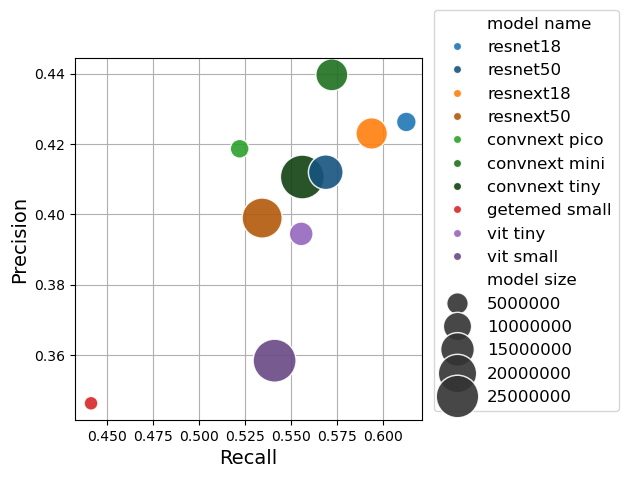

In [15]:
ax = sns.scatterplot(
    data=sorted_data, 
    x="Recall", 
    y="Precision", 
    hue="model_name", 
    hue_order=model_hue_order,
    size="model_size",
    sizes=(100, 1000),
    alpha=0.9,
    palette=custom_cmap.colors,
    zorder=2
)

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

# Change legend titles
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    title="", 
    fontsize=12, 
    bbox_to_anchor=(1.01, 0),  # Set the location
    loc="lower left"          # Anchor point of the legend box
)

for i, text in enumerate(legend.get_texts()):
    _text = text.get_text()
    new_text = _text.replace("_", " ")
    text.set_text(new_text)

plt.grid()
plt.tight_layout()
plt.savefig("./plots/baseline_recall_precision.png", dpi=280)
plt.show()

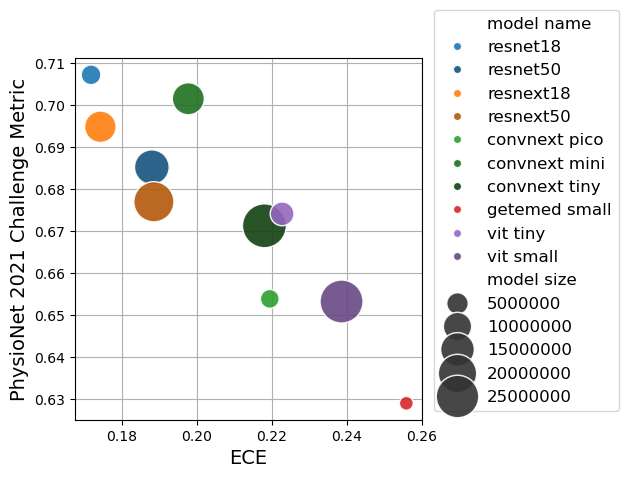

In [16]:
ax = sns.scatterplot(
    data=sorted_data, 
    x="ECE", 
    y="PhysioAccuracy_mean", 
    hue="model_name", 
    hue_order=model_hue_order,
    size="model_size",
    sizes=(100, 1000),
    alpha=0.9,
    palette=custom_cmap.colors,
    zorder=2
)

plt.xlabel("ECE", fontsize=14)
plt.ylabel("PhysioNet 2021 Challenge Metric", fontsize=14)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

# Change legend titles
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    title="", 
    fontsize=12, 
    bbox_to_anchor=(1.01, 0),  # Set the location
    loc="lower left"          # Anchor point of the legend box
)

for i, text in enumerate(legend.get_texts()):
    _text = text.get_text()
    new_text = _text.replace("_", " ")
    text.set_text(new_text)

plt.grid()
plt.tight_layout()
plt.savefig("./plots/baseline_performance_ece.png", dpi=280)
plt.show()

## Evaluate Wd and Lr

In [20]:
model = loader.load(model_name="resnet18", loss_fn="ASL")

WARN: Filter more!! I got 12 samples fitting the criteria {'model_name': 'resnet18', 'loss_fn': 'ASL'}.


## Postprocessing

In [101]:
metrics = scalar_metrics()
physiomet = PhysionetMetric(WEIGHTS, CLASSES, SINUS_RYTHM)
bootstrap = BootStrapper(physiomet, num_bootstraps=5)

def linear_best_threshold(y_pred, y_true, num=50, min_thr=0.3, max_thr=0.8):
    """Simple linear, uniform threshold optimization."""
    num_classes = y_pred.shape[1]
    
    best_thresholds = torch.zeros(26)

    for class_index in range(num_classes):
        thresholds = torch.zeros(26) + 0.5
        
        _best_score = 0.0
        for threshold in torch.linspace(min_thr, max_thr, num):
            thresholds[class_index] = threshold
    
            score = physiomet(y_pred.sigmoid() > thresholds, y_true).item()
    
            if score > _best_score:
                _best_score = score
                best_thresholds[class_index] = threshold
    
    return best_thresholds

In [16]:
model = loader.load(model_name="resnet18", loss_fn="ASL")

In [17]:
# Dataset
valid_transform = ECGAugmentation()
train_transform = ECGAugmentation()
dm = PhysionetDM("/sc-scratch/sc-scratch-gbm-radiomics/ecg/physionet_challenge/training_pt/metadata_v5.csv", train_transform=train_transform, val_transform=valid_transform, fold=0, batch_size=256)
dm.setup()

train_dataloader = dm.train_dataloader()
train_dataloader.num_workers = 32
train_dataloader.prefetch_factor = 2

valid_dataloader = dm.val_dataloader()
valid_dataloader.num_workers = 32
valid_dataloader.prefetch_factor = 2

In [18]:
x, y = next(iter(train_dataloader))

In [181]:
# Finding good thresholds
thresholds = []

for x, y in tqdm(train_dataloader):
    
    with torch.no_grad():
        p = model(x)

    thresh = linear_best_threshold(p, y)
    thresholds.append(thresh)
    break

  0%|          | 0/206 [00:30<?, ?it/s]


In [149]:
thresholds = torch.stack(thresholds, dim=0)

In [150]:
thresholds

tensor([[0.5245, 0.5755, 0.4224,  ..., 0.5449, 0.5143, 0.5959],
        [0.5245, 0.5143, 0.5245,  ..., 0.6163, 0.5041, 0.5347],
        [0.4429, 0.4939, 0.4429,  ..., 0.5959, 0.5245, 0.5449],
        ...,
        [0.5959, 0.5755, 0.4327,  ..., 0.4224, 0.5041, 0.4531],
        [0.4939, 0.5143, 0.4837,  ..., 0.7388, 0.4531, 0.4531],
        [0.5449, 0.3918, 0.4837,  ..., 0.5449, 0.5041, 0.5143]])

In [151]:
thresholds.mean(dim=0)

tensor([0.5231, 0.5112, 0.4842, 0.4757, 0.4938, 0.5083, 0.5306, 0.5354, 0.5203,
        0.4967, 0.5209, 0.4964, 0.5410, 0.4913, 0.5481, 0.5020, 0.4772, 0.5024,
        0.4908, 0.5287, 0.6010, 0.5552, 0.4841, 0.5761, 0.5322, 0.5177])

In [152]:
thresholds.std(dim=0)

tensor([0.0570, 0.0732, 0.0717, 0.0652, 0.0937, 0.0744, 0.0651, 0.0693, 0.0527,
        0.0757, 0.0528, 0.0655, 0.0445, 0.0425, 0.0859, 0.0646, 0.0568, 0.0738,
        0.0696, 0.0509, 0.0708, 0.0544, 0.0612, 0.0877, 0.0340, 0.0546])

In [153]:
final_thresholds = thresholds.mean(dim=0)
final_thresholds

tensor([0.5231, 0.5112, 0.4842, 0.4757, 0.4938, 0.5083, 0.5306, 0.5354, 0.5203,
        0.4967, 0.5209, 0.4964, 0.5410, 0.4913, 0.5481, 0.5020, 0.4772, 0.5024,
        0.4908, 0.5287, 0.6010, 0.5552, 0.4841, 0.5761, 0.5322, 0.5177])

In [155]:
df["mean"] = df["mean"].apply(lambda x: x.item())
df["std"] = df["std"].apply(lambda x: x.item())
df["batch"] = df["batch"].astype("category")

In [226]:
y_all = torch.concatenate(y_all)

In [225]:
ps = torch.concatenate(ps)

<Axes: xlabel='opt', ylabel='mean'>

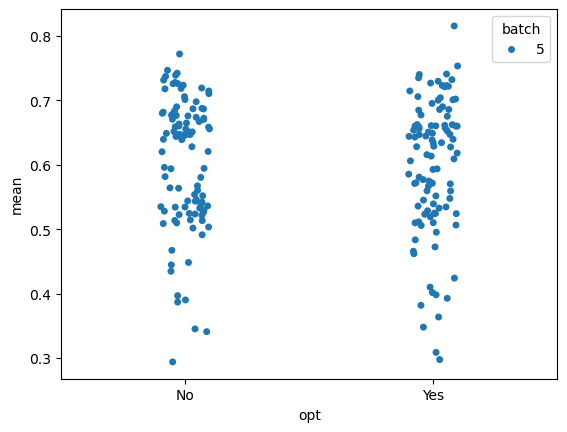

In [173]:
sns.stripplot(df, x="opt", y="mean", hue="batch")

In [227]:
physiomet(ps, y_all)

tensor(0.6122)

In [229]:
physiomet((ps >= best_thresholds).int(), y_all)

tensor(0.5990)

In [242]:
r = evaluate_model(model)

  0%|          | 0/828 [00:00<?, ?it/s]/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
 36%|███▋      | 301/828 [00:18<00:39, 13.48it/s]/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
100%|██████████| 828/828 [00:49<00:00, 16.73it/s]


In [243]:
r

{'AP': 0.49656394124031067,
 'AUROC': 0.9317896962165833,
 'Accuracy': 0.948517918586731,
 'ECE': 0.1791827380657196,
 'F1': 0.48086294531822205,
 'PhysioAccuracy': 0.7034883499145508,
 'Precision': 0.41133642196655273,
 'Recall': 0.6131343245506287,
 'PhysioAccuracy_mean': 0.6199683547019958,
 'PhysioAccuracy_std': 0.0019895476289093494,
 'PhysioAccuracy_quantile': 0.6193960905075073,
 'model_name': ''}

In [231]:
r

{'AP': 0.49656394124031067,
 'AUROC': 0.9317896962165833,
 'Accuracy': 0.948517918586731,
 'ECE': 0.1791827380657196,
 'F1': 0.48086294531822205,
 'PhysioAccuracy': 0.7034883499145508,
 'Precision': 0.41133642196655273,
 'Recall': 0.6131343245506287,
 'PhysioAccuracy_mean': 0.7031352519989014,
 'PhysioAccuracy_std': 0.002094231778755784,
 'PhysioAccuracy_quantile': 0.7034157514572144,
 'model_name': ''}

In [244]:
def compute_modified_confusion_matrix(labels, outputs):
    # Compute a binary multi-class, multi-label confusion matrix, where the rows
    # are the labels and the columns are the outputs.
    num_recordings, num_classes = np.shape(labels)
    A = np.zeros((num_classes, num_classes))

    # Iterate over all of the recordings.
    for i in range(num_recordings):
        # Calculate the number of positive labels and/or outputs.
        normalization = float(max(np.sum(np.any((labels[i, :], outputs[i, :]), axis=0)), 1))
        # Iterate over all of the classes.
        for j in range(num_classes):
            # Assign full and/or partial credit for each positive class.
            if labels[i, j]:
                for k in range(num_classes):
                    if outputs[i, k]:
                        A[j, k] += 1.0/normalization

    return A

# Compute the evaluation metric for the Challenge.
def compute_challenge_metric(weights, labels, outputs, classes, sinus_rhythm):
    num_recordings, num_classes = np.shape(labels)
    if sinus_rhythm in classes:
        sinus_rhythm_index = classes.index(sinus_rhythm)
    else:
        raise ValueError('The sinus rhythm class is not available.')

    # Compute the observed score.
    A = compute_modified_confusion_matrix(labels, outputs)
    observed_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the correct label(s).
    correct_outputs = labels
    A = compute_modified_confusion_matrix(labels, correct_outputs)
    correct_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the sinus rhythm class.
    inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool_)
    inactive_outputs[:, sinus_rhythm_index] = 1
    A = compute_modified_confusion_matrix(labels, inactive_outputs)
    inactive_score = np.nansum(weights * A)

    if correct_score != inactive_score:
        normalized_score = float(observed_score - inactive_score) / float(correct_score - inactive_score)
    else:
        normalized_score = 0.0

    return normalized_score


In [256]:
physiomet(p, y)

tensor(0.5294)

In [257]:
compute_challenge_metric(WEIGHTS, y.numpy(), (p.sigmoid() > 0.5).int().numpy(), CLASSES, SINUS_RYTHM)

0.5294498741657426

In [ ]:
def evaluate_model(model, model_name="", quantile=0.5, num_bootstraps=10):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    model = model.eval().to(device)

    cm = []
    
    # Metrics
    metrics = scalar_metrics()
    physiomet = PhysionetMetric(WEIGHTS, CLASSES, SINUS_RYTHM)
    bootstrap = BootStrapper(physiomet, num_bootstraps=num_bootstraps, quantile=quantile)

    # Dataset
    valid_transform = ECGAugmentation()
    train_transform = ECGAugmentation()
    dm = PhysionetDM("/sc-scratch/sc-scratch-gbm-radiomics/ecg/physionet_challenge/training_pt/metadata_v5.csv", train_transform=train_transform, val_transform=valid_transform, fold=0)
    dm.setup()
    dataloader = dm.val_dataloader()
    dataloader.num_workers = 32
    dataloader.prefetch_factor = 2

    # Evaluate
    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(dataloader, total=len(dataloader), desc=model_name)):
            pred = model(x.to(device))
            pred, y = pred.cpu(), y.int().cpu()

            metrics(pred, y)
            bootstrap.update(pred, y)

    # Format output
    result = metrics.compute()
    for k, v in bootstrap.compute().items():
        result[f"PhysioAccuracy_{k}"] = v

    for k, v in result.items():
        result[k] = v.item()

    result["model_name"] = model_name
    
    return result

In [265]:
x = torch.rand(1, 1024, 12).unfold(1, 256, 256)
x.shape

torch.Size([1, 4, 12, 256])